In [1]:
import nengo
import numpy as np
#import matplotlib.pyplot as plt
#%matplotlib inline

beta = 0.5  # equal weighting for feedforward and feedback connections
model = nengo.Network()
with model:
    
    stim_in = nengo.Node(output=[0.5]) #np.sin)   
    
    state0 = nengo.Ensemble(100, dimensions=1)
    delta0 = nengo.Ensemble(100, dimensions=1)
    
    state1 = nengo.Ensemble(100, dimensions=1)
    error1 = nengo.Ensemble(100, dimensions=1)
    delta1 = nengo.Ensemble(100, dimensions=1)
    
    state2 = nengo.Ensemble(100, dimensions=1)
    error2 = nengo.Ensemble(100, dimensions=1)
    delta2 = nengo.Ensemble(100, dimensions=1)
    
    # state0 connections
    nengo.Connection(stim_in, state0)
    nengo.Connection(state0, delta0)
    nengo.Connection(delta0, state0, transform=-beta)
    
    bwd_1 = nengo.Connection(state1, delta0, transform=-1, 
                function=lambda x: np.random.random(1), 
                solver=nengo.solvers.LstsqL2(weights=True))   # g connection 
   

    # state1 connections
    nengo.Connection(error1, state1, transform=1-beta)
    nengo.Connection(state1, error1, transform=-1)
    nengo.Connection(state1, delta1)
    nengo.Connection(delta1, state1, transform=-beta)
    
    fwd_1 = nengo.Connection(state1, error2, 
                function=lambda x: np.random.random(1), 
                solver=nengo.solvers.LstsqL2(weights=True))  # f connection
    bwd_2 = nengo.Connection(state2, delta1, transform=-1, 
                function=lambda x: np.random.random(1), 
                solver=nengo.solvers.LstsqL2(weights=True))   # g connection
    
   
    # state2 connections
    nengo.Connection(error2, state2, transform=1-beta)
    nengo.Connection(state2, error2, transform=-1)
    nengo.Connection(state2, delta2)
    nengo.Connection(delta2, state2, transform=-beta)
    
    # previous layer
    fwd_0 = nengo.Connection(state0, error1, 
                function=lambda x: np.random.random(1), 
                solver=nengo.solvers.LstsqL2(weights=True))  # f connection - input from previous layer or sensory input
    #bwd_1 = nengo.Connection(state1, delta0)  # g connection - expectation send down
    
    # next layer
    #fwd_2 = nengo.Connection(state2, error3)   # f connection - prediction sent up
    #bwd_3 = nengo.Connection(state3, delta2)   # g connection - expectation from next layer
    
    # copying error ensembles for inhibition to turn off PES learning
    error1_copy = nengo.Ensemble(100, dimensions=1)
    error2_copy = nengo.Ensemble(100, dimensions=1)
    delta0_copy = nengo.Ensemble(100, dimensions=1)
    delta1_copy = nengo.Ensemble(100, dimensions=1)
    nengo.Connection(error1, error1_copy, synapse=0)
    nengo.Connection(error2, error2_copy, synapse=0)
    nengo.Connection(delta0, delta0_copy, synapse=0)
    nengo.Connection(delta1, delta1_copy, synapse=0)
    
    # add learning rule to the f and g connections
    # need to add it to fwd_0, fwd_1, bwd1, bwd_2 
    # fwd_0 => error1
    # fwd_1 => error2
    # bwd_1 => delta0
    # bwd_2 => delta1
    fwd_0.learning_rule_type ={'my_pes': nengo.PES(learning_rate=0.0001), 'my_bcm': nengo.BCM()}
    fwd_1.learning_rule_type ={'my_pes': nengo.PES(learning_rate=0.0001), 'my_bcm': nengo.BCM()}
    bwd_1.learning_rule_type ={'my_pes': nengo.PES(learning_rate=0.0001), 'my_bcm': nengo.BCM()}
    bwd_2.learning_rule_type ={'my_pes': nengo.PES(learning_rate=0.0001), 'my_bcm': nengo.BCM()}
    
    # Error connections don't impart current
    error1_conn = nengo.Connection(error1_copy, fwd_0.learning_rule['my_pes'])
    error2_conn = nengo.Connection(error2_copy, fwd_1.learning_rule['my_pes'])
    delata0_conn = nengo.Connection(delta0_copy, bwd_1.learning_rule['my_pes'])
    delata1_conn = nengo.Connection(delta1_copy, bwd_2.learning_rule['my_pes'])
    
    #function to inhibit the error population after 50 seconds
    def inhib(t):
        return 2.0 if t > 50.0 else 0.0
    
    #Connecting inhibit population to error populations
    inhibit = nengo.Node(inhib)
    nengo.Connection(inhibit, error1_copy.neurons, transform=[[-1]] * error1_copy.n_neurons, synapse=0.01)
    nengo.Connection(inhibit, error2_copy.neurons, transform=[[-1]] * error2_copy.n_neurons, synapse=0.01)
    nengo.Connection(inhibit, delta0_copy.neurons, transform=[[-1]] * delta0_copy.n_neurons, synapse=0.01)
    nengo.Connection(inhibit, delta1_copy.neurons, transform=[[-1]] * delta1_copy.n_neurons, synapse=0.01)
    
    
    # recurrent connections on error and delta
    tau = 0.1
    nengo.Connection(error1, error1, synapse=tau)
    nengo.Connection(error2, error2, synapse=tau)
    nengo.Connection(delta0, delta0, synapse=tau)
    nengo.Connection(delta1, delta1, synapse=tau)
    nengo.Connection(delta2, delta2, synapse=tau)
    

In [2]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "predictive_estimator.py.cfg")

c:\users\susharma\desktop\git\nengo\nengo\builder\optimizer.py:636: UserWarning: Skipping some optimization steps because SciPy is not installed. Installing SciPy may result in faster simulations.
  warnings.warn("Skipping some optimization steps because SciPy is "


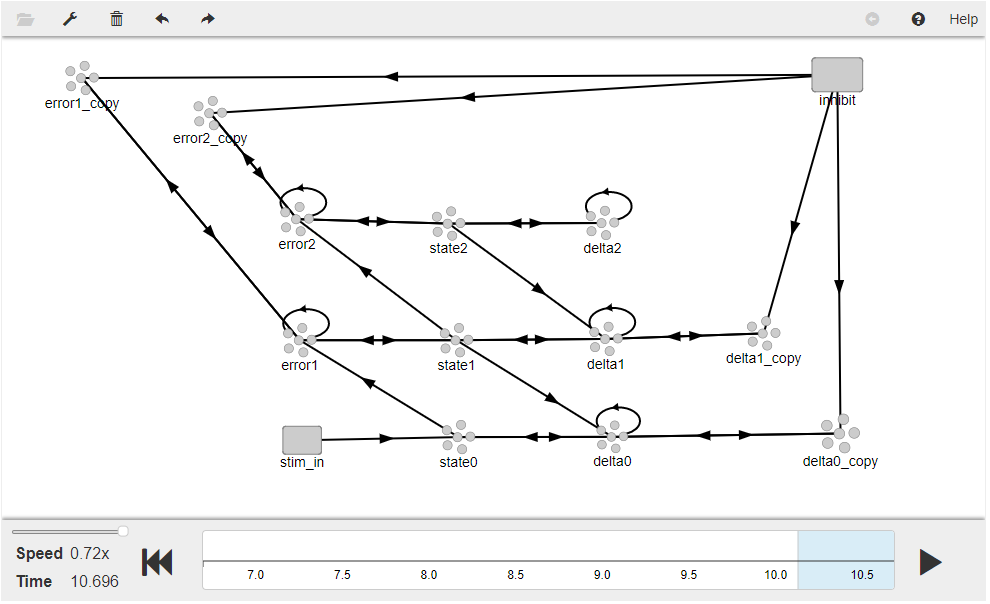

In [4]:
from IPython.display import Image
Image(filename='predictive_estimator.png')

In [ ]:
# 1. Why are post_error1 and post_delata1 ensembles needed to scale by beta (Figure 5.3)?
# 2. Figure 4.1 suggests that there should be recurrent connections from error to itself and delta to itself
#    are they needed in the Nengo model as well?